In [3]:
!pip install kagglehub

     |████████████████████████████████| 42 kB 1.1 MB/s eta 0:00:01
You should consider upgrading via the '/Users/seemanthrajukurapati/Desktop/gan/gan/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

/Users/seemanthrajukurapati/Desktop/gan/gan/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/seemanthrajukurapati/Desktop/gan/gan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.33G/1.33G [01:13<00:00, 19.4MB/s]

Extracting files...


Path to dataset files: /Users/seemanthrajukurapati/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Define the device
device = torch.device("mps" if torch.has_mps else "cpu")  # "mps" for Apple Silicon (M1/M2)
print(f"Using device: {device}")


Using device: mps


/var/folders/t6/5nb86gxs22bdv3d0wnmn9_s40000gn/T/ipykernel_33813/1152196306.py:12: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")  # "mps" for Apple Silicon (M1/M2)


# custom Data Loader

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomCelebADataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image at idx
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        return image



In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
from custom_celeba_dataset import CustomCelebADataset

# Define transformations to resize and normalize images
transform = transforms.Compose([
    transforms.Resize(64),           # Resize images to 64x64
    transforms.CenterCrop(64),       # Center crop
    transforms.ToTensor(),           # Convert to PyTorch tensor
    transforms.Normalize([0.5], [0.5], [0.5])  # Normalize to [-1, 1] for RGB
])

# Path to your image directory
img_dir = "/Users/seemanthrajukurapati/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba"

# Initialize the custom dataset and dataloader
dataset = CustomCelebADataset(img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)




# Model Architecture

In [4]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Initialize the generator
nz = 100  # Latent vector size
netG = Generator(nz=nz).to(device)
print(netG)



Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Initialize the discriminator
netD = Discriminator().to(device)
print(netD)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [6]:
# Loss function
criterion = nn.BCELoss()

# Fixed noise for visualizing progress of generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))



# Training Model

In [9]:
from tqdm import tqdm
from custom_celeba_dataset import CustomCelebADataset
import numpy as np
num_epochs = 25
real_label = 1.
fake_label = 0.

for epoch in range(num_epochs):
    # Initialize tqdm progress bar for the epoch
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch [{epoch + 1}/{num_epochs}]")

    for i, data in pbar:
        # Train Discriminator with real images
        netD.zero_grad()
        real_images = data.to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()

        # Train Discriminator with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        # Train Generator to fool the Discriminator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Update progress bar with loss details
        pbar.set_postfix({
            'Loss_D': f'{lossD.item():.4f}',
            'Loss_G': f'{lossG.item():.4f}',
            'D(x)': f'{D_x:.4f}',
            'D(G(z1))': f'{D_G_z1:.4f}',
            'D(G(z2))': f'{D_G_z2:.4f}'
        })

    # Save generated images at the end of each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    vutils.save_image(fake, f'./output/fake_images_epoch_{epoch}.png', normalize=True)
    print(f"Saved generated images for epoch {epoch + 1}")



Epoch [1/25]: 100%|██████████| 1583/1583 [12:21<00:00,  2.14it/s, Loss_D=0.2610, Loss_G=2.9168, D(x)=0.9260, D(G(z1))=0.1529, D(G(z2))=0.0708]

Saved generated images for epoch 1



Epoch [2/25]: 100%|██████████| 1583/1583 [12:15<00:00,  2.15it/s, Loss_D=0.6686, Loss_G=3.6881, D(x)=0.8137, D(G(z1))=0.3164, D(G(z2))=0.0374] 

Saved generated images for epoch 2



Epoch [3/25]: 100%|██████████| 1583/1583 [12:29<00:00,  2.11it/s, Loss_D=0.1923, Loss_G=3.0000, D(x)=0.9453, D(G(z1))=0.1179, D(G(z2))=0.0649] 

Saved generated images for epoch 3



Epoch [4/25]: 100%|██████████| 1583/1583 [12:32<00:00,  2.10it/s, Loss_D=0.1133, Loss_G=4.1839, D(x)=0.9325, D(G(z1))=0.0375, D(G(z2))=0.0236] 

Saved generated images for epoch 4



Epoch [5/25]: 100%|██████████| 1583/1583 [12:32<00:00,  2.10it/s, Loss_D=0.1628, Loss_G=3.6584, D(x)=0.9477, D(G(z1))=0.0925, D(G(z2))=0.0450] 

Saved generated images for epoch 5



Epoch [6/25]: 100%|██████████| 1583/1583 [12:24<00:00,  2.13it/s, Loss_D=0.1485, Loss_G=4.2032, D(x)=0.9283, D(G(z1))=0.0629, D(G(z2))=0.0238] 

Saved generated images for epoch 6



Epoch [7/25]: 100%|██████████| 1583/1583 [15:40<00:00,  1.68it/s, Loss_D=0.1483, Loss_G=4.2796, D(x)=0.9547, D(G(z1))=0.0900, D(G(z2))=0.0206]  

Saved generated images for epoch 7



Epoch [8/25]: 100%|██████████| 1583/1583 [21:16<00:00,  1.24it/s, Loss_D=0.3223, Loss_G=3.3958, D(x)=0.8508, D(G(z1))=0.1200, D(G(z2))=0.0484]   

Saved generated images for epoch 8



Epoch [9/25]: 100%|██████████| 1583/1583 [19:16<00:00,  1.37it/s, Loss_D=0.3927, Loss_G=3.0346, D(x)=0.8769, D(G(z1))=0.2063, D(G(z2))=0.0616]   


Saved generated images for epoch 9


Epoch [10/25]: 100%|██████████| 1583/1583 [40:36<00:00,  1.54s/it, Loss_D=0.4832, Loss_G=2.7826, D(x)=0.8092, D(G(z1))=0.1802, D(G(z2))=0.1302]    

Saved generated images for epoch 10



Epoch [11/25]: 100%|██████████| 1583/1583 [12:21<00:00,  2.13it/s, Loss_D=0.6630, Loss_G=1.0450, D(x)=0.5761, D(G(z1))=0.0050, D(G(z2))=0.4298] 


Saved generated images for epoch 11


Epoch [12/25]: 100%|██████████| 1583/1583 [21:30<00:00,  1.23it/s, Loss_D=0.2261, Loss_G=3.9744, D(x)=0.9874, D(G(z1))=0.1755, D(G(z2))=0.0272]   

Saved generated images for epoch 12



Epoch [13/25]: 100%|██████████| 1583/1583 [12:26<00:00,  2.12it/s, Loss_D=0.0289, Loss_G=5.8402, D(x)=0.9796, D(G(z1))=0.0074, D(G(z2))=0.0066] 

Saved generated images for epoch 13



Epoch [14/25]: 100%|██████████| 1583/1583 [12:22<00:00,  2.13it/s, Loss_D=0.0224, Loss_G=6.6488, D(x)=0.9806, D(G(z1))=0.0024, D(G(z2))=0.0032] 

Saved generated images for epoch 14



Epoch [15/25]: 100%|██████████| 1583/1583 [12:17<00:00,  2.15it/s, Loss_D=0.0346, Loss_G=6.0048, D(x)=0.9752, D(G(z1))=0.0086, D(G(z2))=0.0049] 


Saved generated images for epoch 15


Epoch [16/25]: 100%|██████████| 1583/1583 [12:15<00:00,  2.15it/s, Loss_D=0.5345, Loss_G=5.6395, D(x)=0.6430, D(G(z1))=0.0001, D(G(z2))=0.0106] 

Saved generated images for epoch 16



Epoch [17/25]: 100%|██████████| 1583/1583 [12:06<00:00,  2.18it/s, Loss_D=0.0489, Loss_G=5.5286, D(x)=0.9607, D(G(z1))=0.0064, D(G(z2))=0.0080] 


Saved generated images for epoch 17


Epoch [18/25]: 100%|██████████| 1583/1583 [12:10<00:00,  2.17it/s, Loss_D=0.0222, Loss_G=6.4404, D(x)=0.9914, D(G(z1))=0.0129, D(G(z2))=0.0043] 


Saved generated images for epoch 18


Epoch [19/25]: 100%|██████████| 1583/1583 [12:11<00:00,  2.16it/s, Loss_D=0.0208, Loss_G=5.8549, D(x)=0.9827, D(G(z1))=0.0030, D(G(z2))=0.0078] 

Saved generated images for epoch 19



Epoch [20/25]: 100%|██████████| 1583/1583 [12:01<00:00,  2.20it/s, Loss_D=0.0346, Loss_G=5.0022, D(x)=0.9836, D(G(z1))=0.0175, D(G(z2))=0.0122] 


Saved generated images for epoch 20


Epoch [21/25]: 100%|██████████| 1583/1583 [11:59<00:00,  2.20it/s, Loss_D=0.0950, Loss_G=4.4605, D(x)=0.9389, D(G(z1))=0.0248, D(G(z2))=0.0250] 

Saved generated images for epoch 21



Epoch [22/25]: 100%|██████████| 1583/1583 [12:09<00:00,  2.17it/s, Loss_D=0.2994, Loss_G=3.7924, D(x)=0.8242, D(G(z1))=0.0557, D(G(z2))=0.0459] 

Saved generated images for epoch 22



Epoch [23/25]: 100%|██████████| 1583/1583 [12:29<00:00,  2.11it/s, Loss_D=0.0783, Loss_G=6.4423, D(x)=0.9963, D(G(z1))=0.0638, D(G(z2))=0.0032] 


Saved generated images for epoch 23


Epoch [24/25]: 100%|██████████| 1583/1583 [12:15<00:00,  2.15it/s, Loss_D=0.0315, Loss_G=6.2319, D(x)=0.9851, D(G(z1))=0.0152, D(G(z2))=0.0064] 


Saved generated images for epoch 24


Epoch [25/25]: 100%|██████████| 1583/1583 [12:30<00:00,  2.11it/s, Loss_D=0.0548, Loss_G=6.2387, D(x)=0.9949, D(G(z1))=0.0440, D(G(z2))=0.0039] 


Saved generated images for epoch 25


# Save the Model

In [10]:
 # Directory to save the model
model_dir = "./trained_models"
os.makedirs(model_dir, exist_ok=True)
 
# Save the generator and discriminator models
torch.save(netG.state_dict(), os.path.join(model_dir, "generator.pth"))
torch.save(netD.state_dict(), os.path.join(model_dir, "discriminator.pth"))
 

# Test the Model

/var/folders/t6/5nb86gxs22bdv3d0wnmn9_s40000gn/T/ipykernel_33813/1563302863.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('/Users/seem

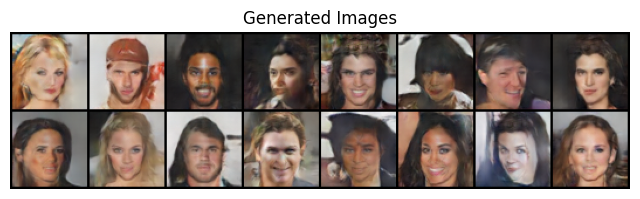

In [14]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
# Define the Generator model class (same as used during training)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
 
    def forward(self, input):
        return self.main(input)
 
# Initialize the generator and load state
nz = 100  # Size of the latent vector (must match what you used in training)
netG = Generator(nz=nz).to('cuda' if torch.cuda.is_available() else 'cpu')
netG.load_state_dict(torch.load('/Users/seemanthrajukurapati/Desktop/gan/trained_models/generator.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
netG.eval()  # Set to evaluation mode
 
## Testing: Generate Images
# Generate random noise as input
num_samples = 16  # Number of images to generate
fixed_noise = torch.randn(num_samples, nz, 1, 1, device='cuda' if torch.cuda.is_available() else 'cpu')
 
# Generate fake images using the generator
with torch.no_grad():  # Disable gradients for faster inference
    fake_images = netG(fixed_noise).detach().cpu()
 
## Testing: Visualize the generated images
# Display generated images in a grid
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
 
 